In [319]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

import xgboost as xgb
import lightgbm as lgbm
import pandas as pd
import numpy as np
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [320]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

In [321]:
test['Target'] = (test['Sales_Contract_No'] != 'None').astype('int')

In [322]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    # Replace each value by the according smoothed mean
    return smooth

In [323]:
train['Target'] = (train.Stage=='Closed Won').astype(int)

In [324]:
train.drop(columns=['Prod_Category_A', 'Actual_Delivery_Date',\
                 'Last_Activity'], inplace=True)
test.drop(columns=['Prod_Category_A', 'Actual_Delivery_Date',\
                 'Last_Activity'], inplace=True)

train['Total_Amount_Sum'] = train.groupby('Opportunity_ID')['Total_Amount'].transform('sum')
test['Total_Amount_Sum'] = test.groupby('Opportunity_ID')['Total_Amount'].transform('sum')

train['ASP_sum_per_Opportunity'] = train.groupby('Opportunity_ID')['ASP'].transform('sum')
train['ASP_converted_sum_per_Opportunity'] = train.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
train['Convertibility']=train['ASP_converted_sum_per_Opportunity'] / train['ASP_sum_per_Opportunity']
test['ASP_sum_per_Opportunity'] = test.groupby('Opportunity_ID')['ASP'].transform('sum')
test['ASP_converted_sum_per_Opportunity'] = test.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
test['Convertibility']=test['ASP_converted_sum_per_Opportunity'] / test['ASP_sum_per_Opportunity']

train['Total_Amount_USD'] = train['Convertibility']*train['Total_Amount']/100000
train['Total_Amount_Sum_USD'] = train['Convertibility']*train['Total_Amount_Sum']/100000
train['Total_Taxable_Amount_USD'] = train['Convertibility']*train['Total_Taxable_Amount']/100000
test['Total_Amount_USD'] = test['Convertibility']*test['Total_Amount']/100000
test['Total_Amount_Sum_USD'] = test['Convertibility']*test['Total_Amount_Sum']/100000
test['Total_Taxable_Amount_USD'] = test['Convertibility']*test['Total_Taxable_Amount']/100000

In [325]:
def acomodar_territorios(df):
    lista_reg = []
    lista_ter = []

    for comb in (df.Region + '-' + df.Territory):
        reg, ter = comb.split('-')
        lista_reg.append(reg)

        if ter == 'Japan':
            lista_ter.append('Japan')
        else:
            lista_ter.append(ter)
    
    df.Region = lista_reg
    df.Territory = lista_ter

In [326]:
def hasData(t):
    for x in t:
        if x != 'None':
            return 1
    return 0

In [327]:
aux = train[(train.Account_Owner!=train.Last_Modified_By) \
            &(train.Opportunity_Owner!=train.Last_Modified_By)]\
            .loc[:, ['Opportunity_Owner', 'Account_Owner', 'Last_Modified_By', 'Opportunity_ID']]

aux.drop_duplicates(subset='Opportunity_ID')

,Opportunity_Owner,Account_Owner,Last_Modified_By,Opportunity_ID
62,Person_Name_39,Person_Name_2,Person_Name_4,19
64,Person_Name_8,Person_Name_8,Person_Name_33,21
66,Person_Name_18,Person_Name_18,Person_Name_39,23
67,Person_Name_18,Person_Name_18,Person_Name_39,24
68,Person_Name_18,Person_Name_18,Person_Name_39,25
...,...,...,...,...
16837,Person_Name_18,Person_Name_18,Person_Name_39,12754
16841,Person_Name_18,Person_Name_18,Person_Name_39,12757
16853,Person_Name_18,Person_Name_18,Person_Name_23,12763
16860,Person_Name_11,Person_Name_63,Person_Name_40,12768


In [328]:
train.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date',
       'Last_Modified_Date', 'Last_Modified_By', 'Product_Family',
       'Product_Name', 'ASP_Currency', 'ASP', 'ASP_(converted)_Currency',
       'ASP_(converted)', 'Planned_Delivery_Start_Date',
       'Planned_Delivery_End_Date', 'Month', 'Delivery_Quarter',
       'Delivery_Year', 'TRF', 'Total_Amount_Currency', 'Total_Amount',
       'Total_Taxable_Amount

In [329]:
def set_df(df):
    
    df['Source '] = df.groupby('Opportunity_ID')['Source '].transform(hasData)
    df['Product_Category_B'] = df.groupby('Opportunity_ID')['Product_Category_B'].transform(hasData)
    df['Price'] = df.groupby('Opportunity_ID')['Price'].transform(hasData)
    df['Size'] = df.groupby('Opportunity_ID')['Size'].transform(hasData)
    df['Product_Type'] = df.groupby('Opportunity_ID')['Product_Type'].transform(hasData)
    df['Brand'] = df.groupby('Opportunity_ID')['Brand'].transform(hasData)
    df['Currency'] = df.groupby('Opportunity_ID')['Currency'].transform(hasData)
    
    df.Opportunity_Created_Date = pd.to_datetime(df.Opportunity_Created_Date, errors='coerce')
    df.Planned_Delivery_Start_Date = pd.to_datetime(df.Planned_Delivery_Start_Date, errors='coerce')
    df.Planned_Delivery_End_Date = pd.to_datetime(df.Planned_Delivery_End_Date, errors='coerce')
    df.Account_Created_Date = pd.to_datetime(df.Account_Created_Date, errors='coerce')
    df.Last_Modified_Date = pd.to_datetime(df.Last_Modified_Date, errors='coerce')

    #Date features (4)
    
    df['Days_Passed'] = df.Last_Modified_Date - df.Opportunity_Created_Date
    df.Days_Passed = df.Days_Passed.astype('timedelta64[D]')
    
    df['Last_Act_Over_End_Date'] = df.Planned_Delivery_End_Date - df.Last_Modified_Date
    df.Last_Act_Over_End_Date = df.Last_Act_Over_End_Date.astype('timedelta64[D]')
    
    df['Last_Act_Over_Start_Date'] = df.Last_Modified_Date - df.Planned_Delivery_Start_Date
    df.Last_Act_Over_Start_Date = df.Last_Act_Over_Start_Date.astype('timedelta64[D]')
    
    df['Last_Activity_In_Time'] = ((df.Last_Modified_Date > df.Planned_Delivery_Start_Date)&(df.Last_Modified_Date<df.Planned_Delivery_End_Date)).astype('int')
    
    df['Wait_Time_Days'] = df.Planned_Delivery_Start_Date - df.Opportunity_Created_Date
    df.Wait_Time_Days = df.Wait_Time_Days.astype('timedelta64[D]')
    
    df['Delivery_Window'] = df.Planned_Delivery_End_Date - df.Planned_Delivery_Start_Date
    df.Delivery_Window = df.Delivery_Window.astype('timedelta64[D]')
    
    df['Wait_Delivery_Cmp'] = df.Wait_Time_Days / df.Delivery_Window
    
    df['Delivered_Hot_Season'] = ((((df.Region=='EMEA')|(df.Region=='Americas')|(df.Region=='Japan')|\
                                   ((df.Region=='APAC')&(df.Territory!='Australia')))\
                                      &\
                                 ((df.Delivery_Quarter=='Q2')|(df.Delivery_Quarter=='Q3')))\
                                      |
                                 ((df.Territory=='Australia')&((df.Delivery_Quarter=='Q1')|(df.Delivery_Quarter=='Q4'))))

    df['USD_Per_Day_Waited'] = df.Total_Amount_Sum_USD/df.Wait_Time_Days

    df['Account_LifeSpan'] = df.Opportunity_Created_Date - df.Account_Created_Date
    df.Account_LifeSpan = df.Account_LifeSpan.astype('timedelta64[D]')
    
    df['Month_Creation'] = df.Opportunity_Created_Date.dt.month
    df['Month_Delivery'] = df.Planned_Delivery_Start_Date.dt.month
    
    #Product features (7)
    df['Total_Products'] = df.groupby('Opportunity_ID')['ID'].transform('count')   
    
    df['Product_Price_Mean'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('mean')
    df['Product_Price_Max'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('max')
    df['Product_Price_Std'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('std')
    df['Product_Price_Min'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('min')
    df['Product_Price_Median'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('median')
    
    #TRF features (6)
    df['Total_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('sum')
    df['Price_Per_TRF'] = (df.Total_Amount_Sum_USD/df.Total_TRF).replace([np.inf, -np.inf], 0)
    df['Mean_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('mean')
    df['Std_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('std')

    #Remap Quote_Type
    df['Quote_Type'] = (df.Quote_Type == 'Non Binding').astype('int')
    
    #Region
    acomodar_territorios(df)

    regions=pd.get_dummies(df['Region'],drop_first=False)
    df = pd.concat([df,regions],axis=1)
    
    #Owners
    df['Owned_By_Same'] = (df.Opportunity_Owner == df.Account_Owner).astype('int')
    
    df['Modified_Not_By_Owner'] = (df.Account_Owner!=df.Last_Modified_By) & \
                                  (df.Opportunity_Owner!=df.Last_Modified_By).astype('int')
    
    df.drop_duplicates(subset=['Opportunity_ID'], inplace=True)
    
    return df.drop(columns=['Region', 'ID', 'Submitted_for_Approval', 'Account_Created_Date', 'Account_Name', \
                     'Opportunity_Name', 'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner', \
                     'Opportunity_Created_Date', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', \
                     'Product_Name', 'ASP_Currency', 'ASP_(converted)_Currency', 'Planned_Delivery_Start_Date', \
                     'Planned_Delivery_End_Date', 'Month', 'Delivery_Quarter', 'TRF', 'Total_Amount_Currency', \
                     'Total_Amount', 'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount', 
                     'Product_Family', 'ASP', 'ASP_(converted)', 'ASP_sum_per_Opportunity', 
                     'ASP_converted_sum_per_Opportunity'])
    

In [330]:
train = set_df(train)
test = set_df(test)

train.drop(columns='Stage', inplace=True)

In [331]:
#Territory and Billing_Country
ter_smooth = calc_smooth_mean(train, 'Territory', 'Target', 1000)
bill_smooth = calc_smooth_mean(train, 'Billing_Country', 'Target', 300)
#train map
train['Territory'] = train['Territory'].map(ter_smooth)
train['Billing_Country'] = train['Billing_Country'].map(bill_smooth)
#test map
test['Territory'] = test['Territory'].map(ter_smooth)
test['Billing_Country'] = test['Billing_Country'].map(bill_smooth)

#Delivery_Terms
deliv_smooth = calc_smooth_mean(train, 'Delivery_Terms', 'Target', 300)
#train map
train['Delivery_Terms'] = train['Delivery_Terms'].map(deliv_smooth)
#test map
test['Delivery_Terms'] = test['Delivery_Terms'].map(deliv_smooth)

#Account_Type
acc_smooth = calc_smooth_mean(train, 'Account_Type', 'Target', 1000)
#train map
train['Account_Type'] = train['Account_Type'].map(acc_smooth)
#test map
test['Account_Type'] = test['Account_Type'].map(acc_smooth)

#Bureaucratic_Code
bur_smooth = calc_smooth_mean(train, 'Bureaucratic_Code', 'Target', 1000)
#train map
train['Bureaucratic_Code'] = train['Bureaucratic_Code'].map(bur_smooth)
#test map
test['Bureaucratic_Code'] = test['Bureaucratic_Code'].map(bur_smooth)

#Opportunity_Type
opp_smooth = calc_smooth_mean(train, 'Opportunity_Type', 'Target', 1000)
#train map
train['Opportunity_Type'] = train['Opportunity_Type'].map(opp_smooth)
#test map
test['Opportunity_Type'] = test['Opportunity_Type'].map(opp_smooth)

#Mix de categoricas
#train['Opp_Acc_Type'] = train.Opportunity_Type * train.Account_Type
#train['Bur_Deliv'] = train.Bureaucratic_Code * train.Delivery_Terms
#train['Terr_Bill'] = train.Territory * train.Billing_Country

#test['Opp_Acc_Type'] = test.Opportunity_Type * test.Account_Type
#test['Bur_Deliv'] = test.Bureaucratic_Code * test.Delivery_Terms
#test['Terr_Bill'] = test.Territory * test.Billing_Country

#train['Opportunity_Type_Price'] = train.Opportunity_Type * train.Total_Amount_Sum_USD
#train['Territory_Price'] = train.Territory * train.Total_Amount_Sum_USD
#test['Opportunity_Type_Price'] = test.Opportunity_Type * test.Total_Amount_Sum_USD
#test['Territory_Price'] = test.Territory * test.Total_Amount_Sum_USD

In [332]:
train

,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Account_Type,...,Price_Per_TRF,Mean_TRF,Std_TRF,APAC,Americas,EMEA,Japan,Middle East,Owned_By_Same,Modified_Not_By_Owner
0,0.525774,1,1,1,1,0.583894,0,0.493687,0,0.489826,...,5.964044,10.0,NaN,0,0,1,0,0,0,False
1,0.525774,0,0,0,0,0.583894,0,0.493687,1,0.489826,...,0.000000,0.0,NaN,0,0,1,0,0,0,False
2,0.568900,0,0,0,0,0.583894,1,0.457969,2,0.385590,...,0.000000,0.0,NaN,0,1,0,0,0,0,False
3,0.568900,1,0,1,0,0.346803,1,0.457969,3,0.385590,...,5.301344,14.0,NaN,0,1,0,0,0,1,False
4,0.568900,1,0,1,0,0.346803,1,0.457969,4,0.385590,...,5.342877,25.0,NaN,0,1,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16939,0.512654,1,1,0,0,0.583894,1,0.512822,12799,0.644207,...,4.543578,1.0,NaN,0,0,1,0,0,1,False
16940,0.458099,1,0,0,0,0.346803,0,0.512822,12800,0.385590,...,5.333125,20.0,0.0,0,1,0,0,0,1,False
16942,0.534883,1,1,1,1,0.583894,1,0.567705,12801,0.385590,...,0.000000,0.0,0.0,0,0,1,0,0,1,False
16945,0.458099,1,1,1,1,0.583894,0,0.457969,12802,0.385590,...,5.866992,4.0,NaN,0,1,0,0,0,1,False


In [333]:
test

,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Account_Type,...,Price_Per_TRF,Mean_TRF,Std_TRF,APAC,Americas,EMEA,Japan,Middle East,Owned_By_Same,Modified_Not_By_Owner
0,0.532401,1,1,1,1,0.583894,1,0.512822,10689,0.644207,...,0.000000,0.0,0.000000,0,0,1,0,0,1,False
3,0.532401,1,1,1,1,0.583894,1,0.512822,10690,0.644207,...,8.571262,0.2,0.447214,0,0,1,0,0,1,False
8,0.458099,1,1,0,0,0.583894,1,0.457969,10691,0.489826,...,0.000000,0.0,NaN,0,1,0,0,0,1,False
9,0.568900,1,1,1,0,0.490531,1,0.457969,10692,0.644207,...,3.615177,1.0,0.000000,0,1,0,0,0,1,False
15,0.568900,0,0,0,0,0.583894,1,0.457969,10693,0.644207,...,0.000000,0.0,NaN,0,1,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,0.514224,1,1,0,0,0.583894,1,0.516458,12364,0.644207,...,0.000000,0.0,0.000000,0,0,1,0,0,1,False
2547,0.477160,1,1,0,0,0.583894,0,0.457969,12365,0.489826,...,0.000000,0.0,NaN,0,1,0,0,0,1,False
2548,0.477160,1,1,1,1,0.583894,0,0.457969,12366,0.489826,...,0.000000,0.0,NaN,0,1,0,0,0,1,False
2549,0.458099,1,1,0,0,0.583894,0,0.457969,12367,0.489826,...,0.000000,0.0,NaN,0,1,0,0,0,1,False


In [334]:
X = train.drop(columns=['Target', 'Opportunity_ID'])
y = train.Target

In [335]:
display(X.shape)
display(y.shape)
test.shape

(9841, 53)

(9841,)

(1567, 55)

In [336]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

mean = xgb.XGBClassifier()

mean.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
#con train

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

classifier = xgb.XGBClassifier()

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [100, 200, 250, 300, 350, 500]
    
}

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=25, scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)

random_search.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  6.8min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [337]:
pred = mean.predict_proba(X_test)

tst = pd.DataFrame(pred)
tst['real'] = y_test.to_list()
tst.loc[:, [1, 'real']]

,1,real
0,0.667944,0
1,0.266162,0
2,0.987757,1
3,0.000083,0
4,0.000437,0
...,...,...
1964,0.004448,0
1965,0.998092,1
1966,0.980255,1
1967,0.020148,0


In [338]:
log_loss(y_test, pred)

0.3287705465188395

In [341]:
test_ft = test.drop(columns=['Opportunity_ID', 'Target'])

test_pred = mean.predict_proba(test_ft)
test_pred

array([[0.00434905, 0.99565095],
       [0.7028585 , 0.2971415 ],
       [0.6698234 , 0.33017656],
       ...,
       [0.9470124 , 0.05298758],
       [0.0490101 , 0.9509899 ],
       [0.9829291 , 0.01707086]], dtype=float32)

In [342]:
test['Prediction'] = pd.DataFrame(test_pred)[1].to_list()
test.loc[:, ['Opportunity_ID', 'Target', 'Prediction']]

,Opportunity_ID,Target,Prediction
0,10689,1,0.995651
3,10690,1,0.297141
8,10691,1,0.330177
9,10692,1,0.003527
15,10693,1,0.990264
...,...,...,...
2545,12364,1,0.998805
2547,12365,1,0.068763
2548,12366,1,0.052988
2549,12367,0,0.950990


In [343]:
log_loss(test.Target, test.Prediction)

0.6954676049994071

In [265]:
random_search.best_params_

{'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.3}

In [344]:
clf = xgb.XGBClassifier()

clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [345]:
test_pred_1 = clf.predict_proba(test_ft)
test['Prediction_2'] = pd.DataFrame(test_pred_1)[1].to_list()
test.loc[:, ['Opportunity_ID', 'Target', 'Prediction_2']]

,Opportunity_ID,Target,Prediction_2
0,10689,1,0.998570
3,10690,1,0.888599
8,10691,1,0.335121
9,10692,1,0.010723
15,10693,1,0.993726
...,...,...,...
2545,12364,1,0.997530
2547,12365,1,0.064263
2548,12366,1,0.089467
2549,12367,0,0.945106


In [346]:
log_loss(test.Target, test.Prediction_2)

0.6315306989412028

<Figure size 720x720 with 0 Axes>

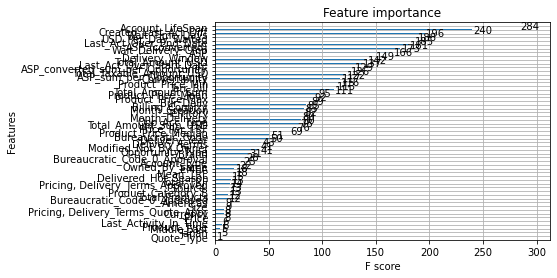

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_importance(clf)
plt.show()

In [347]:
f_imp = clf.feature_importances_
f = X_test.columns

In [350]:
for i in range (len(f_imp)):
    print("{: >10}\t\t{: >50}".format(f[i],f_imp[i]))
    t+=f_imp[i]

 Territory		                              0.011556432582437992
Pricing, Delivery_Terms_Quote_Appr		                             0.0037575955502688885
Pricing, Delivery_Terms_Approved		                              0.007168671116232872
Bureaucratic_Code_0_Approval		                              0.008465680293738842
Bureaucratic_Code_0_Approved		                              0.003598293988034129
Bureaucratic_Code		                               0.01673620007932186
   Source 		                              0.007146484684199095
Billing_Country		                              0.015326051972806454
Account_Type		                               0.00543585978448391
Opportunity_Type		                              0.011600739322602749
Quote_Type		                                               0.0
Delivery_Terms		                              0.009045765735208988
     Brand		                               0.11882103234529495
Product_Type		                               0.02508876658976078
      Size

In [ ]:
#test['Target'] = pd.DataFrame(test_pred)[1].to_list()
#test.loc[:, ['Opportunity_ID', 'Target']].to_csv('submission.csv', index=False)

In [366]:
train.groupby('Source ').agg({'Target':['mean', 'count']})

Target      
             mean count
Source                 
0        0.509776  4910
1        0.520990  4931

In [363]:
test.groupby('Price').agg({'Target':['sum', 'count']})

Target      
         sum count
Price             
0        793  1333
1          6   234